/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


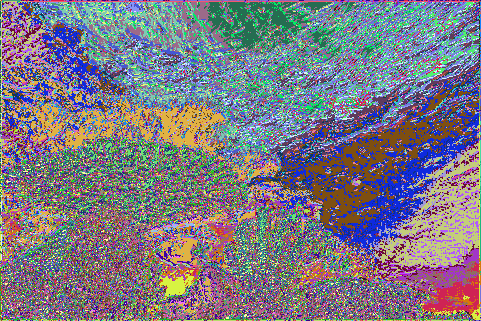

0 / 1000 |  label num : 100  | loss : 3.9759082794189453


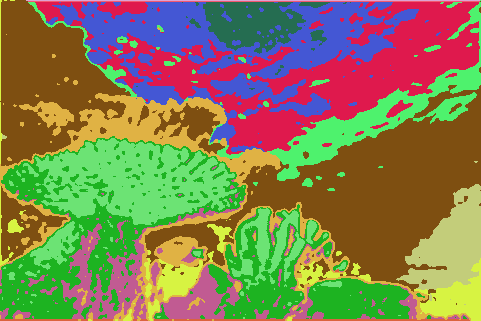

100 / 1000 |  label num : 14  | loss : 0.16920648515224457


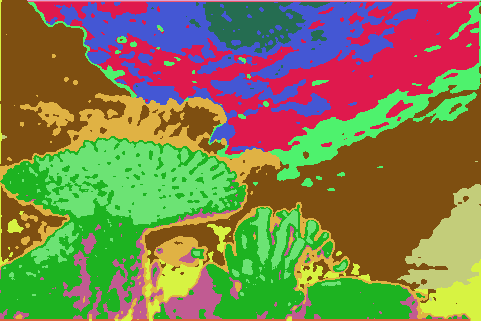

200 / 1000 |  label num : 14  | loss : 0.1250144988298416


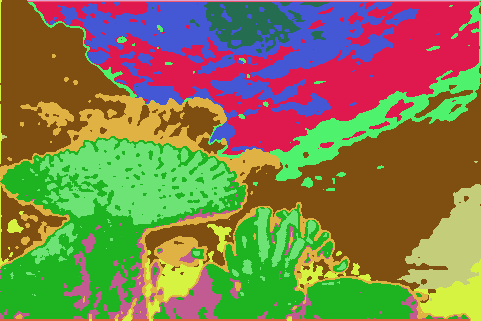

300 / 1000 |  label num : 14  | loss : 0.10418467223644257


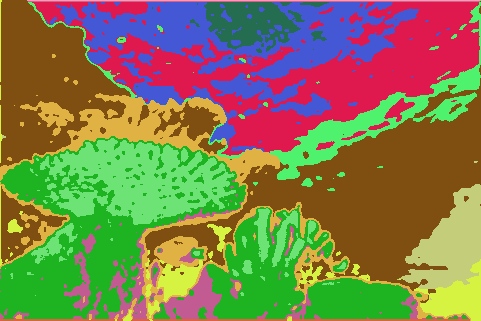

400 / 1000 |  label num : 14  | loss : 0.09297230839729309


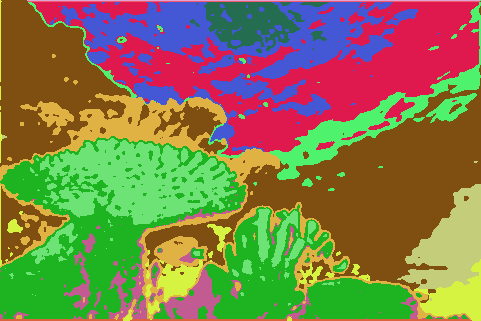

500 / 1000 |  label num : 14  | loss : 0.08393862098455429


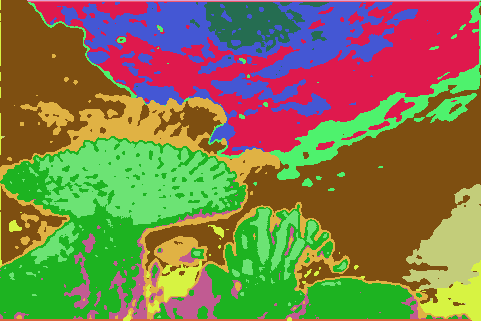

600 / 1000 |  label num : 14  | loss : 0.0900440514087677


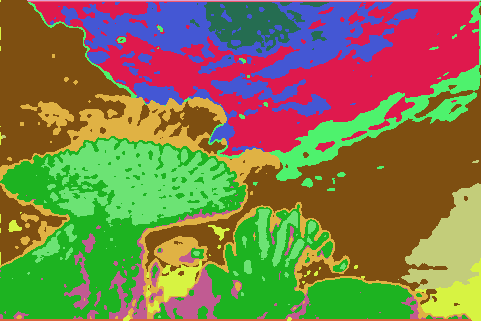

700 / 1000 |  label num : 14  | loss : 0.07342187315225601


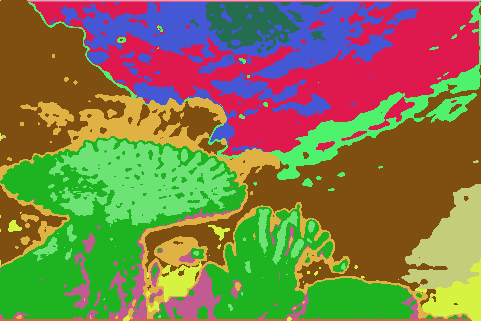

800 / 1000 |  label num : 14  | loss : 0.07129086554050446


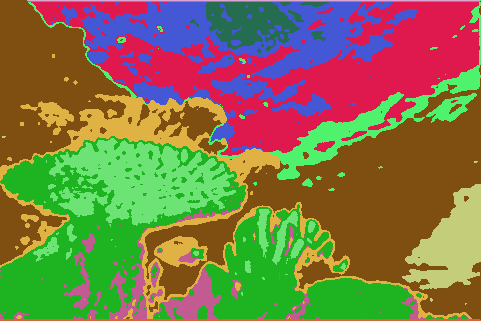

900 / 1000 |  label num : 13  | loss : 0.06452862918376923


True

In [ ]:
#from _future_ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import cv2
import sys
import numpy as np
import torch.nn.init
import random
from google.colab.patches import cv2_imshow

use_cuda = torch.cuda.is_available()


class variables:
  nChannel=100
  maxIter=1000
  minLabels=4
  lr=0.1
  nConv=2
  visualize=1
  input="./images/101027.jpg"
  scribble=False
  stepsize_sim=1
  stepsize_con=1
  stepsize_scr=0.5

args=variables()



# CNN model
class MyNet(nn.Module):
    def __init__(self,input_dim):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(input_dim, args.nChannel, kernel_size=3, stride=1, padding=1 )
        self.bn1 = nn.BatchNorm2d(args.nChannel)
        self.conv2 = nn.ModuleList()
        self.bn2 = nn.ModuleList()
        for i in range(args.nConv-1):
            self.conv2.append( nn.Conv2d(args.nChannel, args.nChannel, kernel_size=3, stride=1, padding=1 ) )
            self.bn2.append( nn.BatchNorm2d(args.nChannel) )
        self.conv3 = nn.Conv2d(args.nChannel, args.nChannel, kernel_size=1, stride=1, padding=0 )
        self.bn3 = nn.BatchNorm2d(args.nChannel)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu( x )
        x = self.bn1(x)
        for i in range(args.nConv-1):
            x = self.conv2[i](x)
            x = F.relu( x )
            x = self.bn2[i](x)
        x = self.conv3(x)
        x = self.bn3(x)
        return x

# load image
im = cv2.imread(args.input)
data = torch.from_numpy( np.array([im.transpose( (2, 0, 1) ).astype('float32')/255.]) )
if use_cuda:
    data = data.cuda()
data = Variable(data)

# train
model = MyNet(data.size(1))
if use_cuda:
    model.cuda()
model.train()

# similarity loss definition
loss_fn = torch.nn.CrossEntropyLoss()

# # scribble loss definition
# loss_fn_scr = torch.nn.CrossEntropyLoss()

# continuity loss definition
loss_hpy = torch.nn.L1Loss(size_average = True)
loss_hpz = torch.nn.L1Loss(size_average = True)

HPy_target = torch.zeros(im.shape[0]-1, im.shape[1], args.nChannel)
HPz_target = torch.zeros(im.shape[0], im.shape[1]-1, args.nChannel)
if use_cuda:
    HPy_target = HPy_target.cuda()
    HPz_target = HPz_target.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
label_colours = np.random.randint(255,size=(100,3))
loss_history = []

for batch_idx in range(args.maxIter):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, args.nChannel )

    outputHP = output.reshape( (im.shape[0], im.shape[1], args.nChannel) )
    HPy = outputHP[1:, :, :] - outputHP[0:-1, :, :]
    HPz = outputHP[:, 1:, :] - outputHP[:, 0:-1, :]
    lhpy = loss_hpy(HPy,HPy_target)
    lhpz = loss_hpz(HPz,HPz_target)

    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
    if args.visualize:
      if(batch_idx%100 == 0):
        im_target_rgb = np.array([label_colours[ c % args.nChannel ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
        cv2_imshow( im_target_rgb )
        cv2.waitKey(10)

    # # loss 
    # if args.scribble:
    #     loss = args.stepsize_sim * loss_fn(output[ inds_sim ], target[ inds_sim ]) + args.stepsize_scr * loss_fn_scr(output[ inds_scr ], target_scr[ inds_scr ]) + args.stepsize_con * (lhpy + lhpz)
    # else:
    loss = args.stepsize_sim * loss_fn(output, target) + args.stepsize_con * (lhpy + lhpz)
    loss_history.append(loss.item())    
    loss.backward()
    optimizer.step()
    if(batch_idx%100 == 0):
        print (batch_idx, '/', args.maxIter, '|', ' label num :', nLabels, ' | loss :', loss.item())

    if nLabels <= args.minLabels:
        print ("nLabels", nLabels, "reached minLabels", args.minLabels, ".")
        break

# save output image
if not args.visualize:
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, args.nChannel )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    im_target_rgb = np.array([label_colours[ c % args.nChannel ] for c in im_target])
    im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
cv2.imwrite( "output.png", im_target_rgb )

Text(0, 0.5, 'Loss')

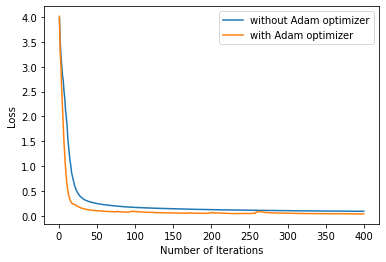

In [ ]:
import matplotlib.pyplot as plt

iters = [i+1 for i in range(400)]
plt.plot(iters, loss_history[:400], iters, loss_his2)
plt.legend(["without Adam optimizer", "with Adam optimizer"])
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")

In [ ]:
loss_his2 =  [4.013881683349609,
3.307138681411743,
 3.005458354949951,
 2.5383834838867188,
 2.1708521842956543,
 1.7897007465362549,
 1.4823410511016846,
 1.2097628116607666,
 0.9611818790435791,
 0.7724804878234863,
 0.6249293684959412,
 0.513647198677063,
 0.42768189311027527,
 0.36571717262268066,
 0.319761723279953,
 0.28570425510406494,
 0.2584479749202728,
 0.247725710272789,
 0.23677292466163635,
 0.23748750984668732,
 0.22762495279312134,
 0.21683786809444427,
 0.207645446062088,
 0.1979367583990097,
 0.18876633048057556,
 0.1806751787662506,
 0.1735992729663849,
 0.16758474707603455,
 0.1620756834745407,
 0.1562252938747406,
 0.14992430806159973,
 0.14578121900558472,
 0.14282891154289246,
 0.13957983255386353,
 0.1359643042087555,
 0.1319720447063446,
 0.1284675896167755,
 0.12544208765029907,
 0.12306615710258484,
 0.12098493427038193,
 0.11857334524393082,
 0.11645503342151642,
 0.11469455808401108,
 0.11266486346721649,
 0.11089816689491272,
 0.10887746512889862,
 0.10740833729505539,
 0.10595068335533142,
 0.10469555854797363,
 0.10288474708795547,
 0.10182085633277893,
 0.1021164134144783,
 0.10054095089435577,
 0.0987965315580368,
 0.09809333086013794,
 0.09775422513484955,
 0.09484607726335526,
 0.09622322022914886,
 0.09295903146266937,
 0.09271183609962463,
 0.09190553426742554,
 0.0903031975030899,
 0.08955220878124237,
 0.08860567212104797,
 0.08682921528816223,
 0.08594517409801483,
 0.08518996089696884,
 0.08361896872520447,
 0.08352626860141754,
 0.08373290300369263,
 0.08416131138801575,
 0.0830020159482956,
 0.08169828355312347,
 0.07789558172225952,
 0.08648239076137543,
 0.08683837950229645,
 0.08787712454795837,
 0.08751235902309418,
 0.08335466682910919,
 0.08240246772766113,
 0.0783383846282959,
 0.08210480213165283,
 0.08038318157196045,
 0.07672158628702164,
 0.07947379350662231,
 0.07856084406375885,
 0.07954654097557068,
 0.07797716557979584,
 0.07733811438083649,
 0.07591114938259125,
 0.07367077469825745,
 0.07323716580867767,
 0.08017079532146454,
 0.08276068419218063,
 0.09156039357185364,
 0.091963991522789,
 0.08912483602762222,
 0.09076039493083954,
 0.08748532831668854,
 0.08717252314090729,
 0.0864180326461792,
 0.08554404973983765,
 0.08505386114120483,
 0.08438283205032349,
 0.0829901248216629,
 0.08199533820152283,
 0.08078348636627197,
 0.07914969325065613,
 0.07790976762771606,
 0.07660911977291107,
 0.07556787133216858,
 0.07468892633914948,
 0.07338029891252518,
 0.07326525449752808,
 0.07450826466083527,
 0.07403749227523804,
 0.07227453589439392,
 0.07095767557621002,
 0.07057322561740875,
 0.06951962411403656,
 0.06877291202545166,
 0.07038076967000961,
 0.07117682695388794,
 0.06948056817054749,
 0.0671110451221466,
 0.06689432263374329,
 0.06579716503620148,
 0.06635932624340057,
 0.0655524730682373,
 0.06393451988697052,
 0.06401743739843369,
 0.06356607377529144,
 0.062386248260736465,
 0.06204535812139511,
 0.06222517043352127,
 0.061467546969652176,
 0.06086006760597229,
 0.061675526201725006,
 0.06288886070251465,
 0.06014135479927063,
 0.0612032450735569,
 0.059784069657325745,
 0.05874359607696533,
 0.059790000319480896,
 0.060344845056533813,
 0.05878465622663498,
 0.05779499560594559,
 0.05789825692772865,
 0.0578438863158226,
 0.05668476223945618,
 0.058203961700201035,
 0.05878841131925583,
 0.05743558704853058,
 0.05845628306269646,
 0.0576510950922966,
 0.056029558181762695,
 0.0569210946559906,
 0.056399375200271606,
 0.0553264394402504,
 0.05512085184454918,
 0.0556444488465786,
 0.05447769910097122,
 0.054469995200634,
 0.05419094115495682,
 0.053458746522665024,
 0.053465090692043304,
 0.05296286568045616,
 0.05221053585410118,
 0.060703128576278687,
 0.057684145867824554,
 0.05763537809252739,
 0.05715935677289963,
 0.05631488934159279,
 0.05619271099567413,
 0.05527713894844055,
 0.05475902184844017,
 0.054749421775341034,
 0.054431598633527756,
 0.05362685024738312,
 0.05330130457878113,
 0.05316685140132904,
 0.053403593599796295,
 0.05315788835287094,
 0.05356595665216446,
 0.0524926520884037,
 0.05223850533366203,
 0.05216684192419052,
 0.052461348474025726,
 0.05221043527126312,
 0.05210976302623749,
 0.0513678640127182,
 0.052387870848178864,
 0.0524221807718277,
 0.05361245200037956,
 0.05273307487368584,
 0.05288592725992203,
 0.05140022188425064,
 0.05630113184452057,
 0.06212738901376724,
 0.06863328069448471,
 0.06784210354089737,
 0.06372237950563431,
 0.05952302739024162,
 0.05867795646190643,
 0.057161226868629456,
 0.05961309373378754,
 0.059363894164562225,
 0.05890841409564018,
 0.0580005943775177,
 0.05657491087913513,
 0.054964207112789154,
 0.053274258971214294,
 0.0560956746339798,
 0.05340325087308884,
 0.053583670407533646,
 0.053016297519207,
 0.052421361207962036,
 0.05178103595972061,
 0.05165829509496689,
 0.05069783702492714,
 0.05002355948090553,
 0.04972035437822342,
 0.04954739660024643,
 0.04905053973197937,
 0.04825342446565628,
 0.04763760417699814,
 0.04710110276937485,
 0.04679218679666519,
 0.046373654156923294,
 0.04605009779334068,
 0.04576978087425232,
 0.04628346860408783,
 0.045879460871219635,
 0.04519836977124214,
 0.04683290794491768,
 0.046786122024059296,
 0.04684670269489288,
 0.04658830910921097,
 0.04915378987789154,
 0.04858680069446564,
 0.04985474422574043,
 0.048935577273368835,
 0.04764196276664734,
 0.046074431389570236,
 0.04668726027011871,
 0.0499064102768898,
 0.048986610025167465,
 0.048993777483701706,
 0.04854931682348251,
 0.045998360961675644,
 0.04697258025407791,
 0.04901370406150818,
 0.0505901575088501,
 0.05294753238558769,
 0.05305778980255127,
 0.05213472992181778,
 0.05053722858428955,
 0.054930008947849274,
 0.07893389463424683,
 0.07882120460271835,
 0.08180521428585052,
 0.08630673587322235,
 0.08644630014896393,
 0.08309268206357956,
 0.08169795572757721,
 0.07871430367231369,
 0.07771453261375427,
 0.07588829845190048,
 0.07037753611803055,
 0.06999866664409637,
 0.06890397518873215,
 0.0668540894985199,
 0.06580118834972382,
 0.06539280712604523,
 0.06408610194921494,
 0.06295739114284515,
 0.06264376640319824,
 0.0625380352139473,
 0.061220914125442505,
 0.060062579810619354,
 0.05946461111307144,
 0.05883805453777313,
 0.057943567633628845,
 0.05749870464205742,
 0.057160384953022,
 0.05686074495315552,
 0.05610765516757965,
 0.05524080991744995,
 0.054863519966602325,
 0.05456918478012085,
 0.053963955491781235,
 0.053442709147930145,
 0.053208738565444946,
 0.05278857797384262,
 0.052386004477739334,
 0.052167102694511414,
 0.05183033645153046,
 0.05156493932008743,
 0.05135355889797211,
 0.05094815790653229,
 0.050772495567798615,
 0.05040287971496582,
 0.050078488886356354,
 0.04995506629347801,
 0.04960212484002113,
 0.04920874536037445,
 0.04914926737546921,
 0.04880218952894211,
 0.04856213927268982,
 0.04836484044790268,
 0.04811454564332962,
 0.047892726957798004,
 0.0477408766746521,
 0.04760398715734482,
 0.04765846207737923,
 0.047304317355155945,
 0.04694513604044914,
 0.04682186618447304,
 0.04668597877025604,
 0.04662926495075226,
 0.04662667587399483,
 0.046331703662872314,
 0.0462782084941864,
 0.0458592064678669,
 0.0457783043384552,
 0.045679327100515366,
 0.04565040022134781,
 0.04540908336639404,
 0.04507060348987579,
 0.04487492889165878,
 0.0451270267367363,
 0.04538007080554962,
 0.045118723064661026,
 0.04490593075752258,
 0.04463726654648781,
 0.04425164684653282,
 0.043919194489717484,
 0.04394412040710449,
 0.04386604204773903,
 0.04374668002128601,
 0.043562013655900955,
 0.04328344762325287,
 0.04332989454269409,
 0.0431639738380909,
 0.04282417520880699,
 0.042814675718545914,
 0.04301981255412102,
 0.042918555438518524,
 0.04275410622358322,
 0.04252993315458298,
 0.04229147359728813,
 0.04204658418893814,
 0.042418643832206726,
 0.042111705988645554,
 0.04226771742105484,
 0.04184393584728241,
 0.04232418164610863,
 0.042748868465423584,
 0.04202716052532196,
 0.04245055839419365,
 0.04174717515707016,
 0.04187124967575073,
 0.04269944503903389,
 0.04328460991382599,
 0.044190406799316406,
 0.04426512494683266,
 0.04411609470844269,
 0.04391138255596161,
 0.04373078793287277,
 0.04368621110916138,
 0.043264709413051605,
 0.04285507649183273,
 0.042751677334308624,
 0.042636822909116745,
 0.04242897406220436,
 0.042184025049209595,
 0.042506445199251175,
 0.04187370091676712,
 0.041683487594127655,
 0.04166646674275398,
 0.0411580428481102,
 0.041331835091114044,
 0.04115796089172363,
 0.041141536086797714,
 0.040828242897987366,
 0.04116564989089966,
 0.04050948843359947,
 0.04077567160129547,
 0.040662121027708054,
 0.04048757255077362,
 0.040187787264585495,
 0.040287744253873825,
 0.039622507989406586,
 0.03950441628694534,
 0.04006035625934601,
 0.039117954671382904,
 0.03917684406042099,
 0.0411403626203537,
 0.04014282673597336,
 0.03915729373693466]

In [ ]:
label_num

NameError: ignored

Text(0, 0.5, 'Loss')

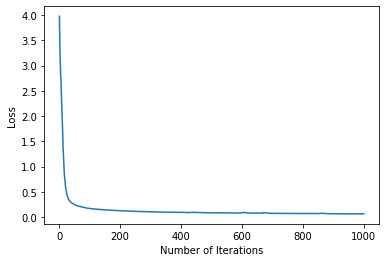

In [ ]:
iters = [i+1 for i in range(1000)]
plt.plot(iters, loss_history)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")

In [ ]:
loss_his2[-1]

0.03915729373693466